In [308]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import ttest_ind

##  Зависимость ошибки второго рода от величины эффекта
$\mu$ и $std$ мы можно оценить по историческим данным,

$\alpha$ и $\beta$ — определяем сами

Смоделируем ситуации, когда ожидаемый и реальный эффект не совпадают, посмотрим, как будет меняться ошибка второго рода.

In [325]:
def check_ttest(a, b, alpha=0.05):
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

In [360]:
mu = 100
std = 50
alpha = 0.05
beta = 0.2
effect_size = 1.05
effect_sizes = np.linspace(1.01, 1.09, 9)

# standardized effect size, difference between the two means divided
# by the standard deviation. `effect_size` has to be positive.
standardized_effect_size = (effect_size - 1) * mu / std
sample_size = tt_ind_solve_power(effect_size=standardized_effect_size,
                                nobs1=None,
                                alpha=alpha,
                                power=1 - beta,
                                ratio=1.0,
                                alternative='two-sided')
sample_size = int(np.ceil(sample_size))

print(f'sample_size = {sample_size}')

sample_size = 1571


In [361]:
errors = []
for effect_size in effect_sizes:
    ab_results = []
    for _ in range(3000):
        a = np.random.normal(loc=mu,
                             scale=std,
                             size=sample_size)
        b = np.random.normal(loc=mu*effect_size,
                             scale=std,
                             size=sample_size )

        ab_results.append(check_ttest(a, b))
    errors.append(1 - np.mean(ab_results))

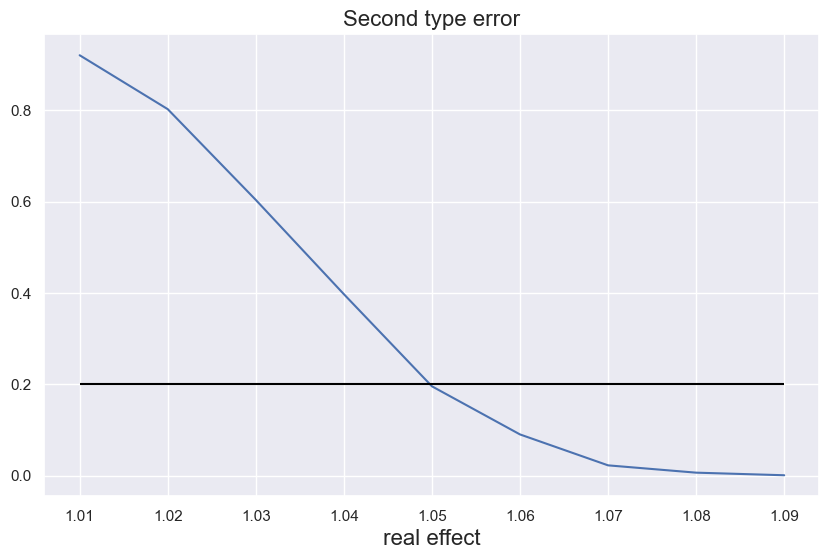

In [362]:
plt.figure(figsize=(10, 6))
plt.plot(effect_sizes, errors)
plt.title('Second type error', fontsize=16)
plt.hlines(0.2, 1.01, 1.09, color ='black')
plt.xlabel('real effect', fontsize=16)
plt.show()

Для эффекта в 5% был посчитан размер выборки(sample_size), затем, используя этот размер выборки, моделируется ситуация с различнымы размерами эффекта.
Если дизайн эксперимента верен, при эффекте 5%  мощность теста соответствует 80%. В случае если мы ошиблись в эффекте на 1%, думали будет 5%, а оказалось 4%, то это увеличивает ошибку второго рода в два раза, с 20% до 40%.

Если есть возможность, лучше собирать данные с запасом.

### Контроль вероятности ошибки I рода
Необходимо убедиться, что если мы многократно запускаем А/А тесты, то $p-value$  имеет равномерное распределение

In [416]:
p_values = []
for _ in range(1000):
    a_one = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size)
    a_two = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size )
    _, pvalue = ttest_ind(a_one, a_two)
    
    p_values.append(pvalue)

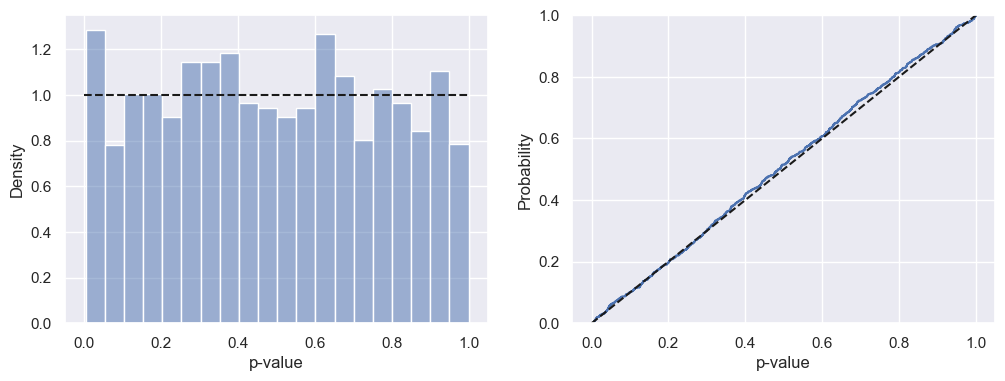

In [418]:
def plot_hist_and_ecdf(p_values, add_hline=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(p_values, ax=ax1, alpha=0.5, bins = 20, stat='density')
    ax1.plot([0, 1], [1, 1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    # empirical cumulative distribution functions
    sns.ecdfplot(p_values, ax=ax2, stat='proportion')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    if add_hline:
        ax2.plot([0.05, 0.05], [0, 1], 'k-', alpha=0.5)

    ax.set(xlabel='p_value')
    
plot_hist_and_ecdf(p_values)

При **отсутствии** эффекта мы должны контролировать вероятность ошибки 1-го рода, то есть
* на уровне значимости 0.0 мы должны ошибаться в среднем в 0 случаях из 100
(то есть всегда говорим, что отличий нет)
* на уровне значимости 0.05 мы должны ошибаться в среднем в 5 случаях из 100
* на уровне значимости 0.1 мы должны ошибаться в среднем в 10 случаях из 100
* на уровне значимости 0.2 мы должны ошибаться в среднем в 20 случаях из 100
* на уровне значимости 1.0 мы должны ошибаться в среднем в 100 случаях из 100
(то есть всегда говорим, что отличия есть)

### Контроль вероятности ошибки 2-го рода
Также необходимо убедиться, что если на самом деле эффект, равный MDE, присутствует, то мы должны в среднем обнаруживать его в $(1 - {\beta})$ % случаев . То есть если верна альтернативная гипотеза, то функция распределения $p-value$ должна быть выпуклой и равняться мощности теста на заданном уровне значимости.

$$F_{p-value | H_1}(\alpha) = \mathbb{P}(p-value < \alpha | H_1) = 1 - \beta$$

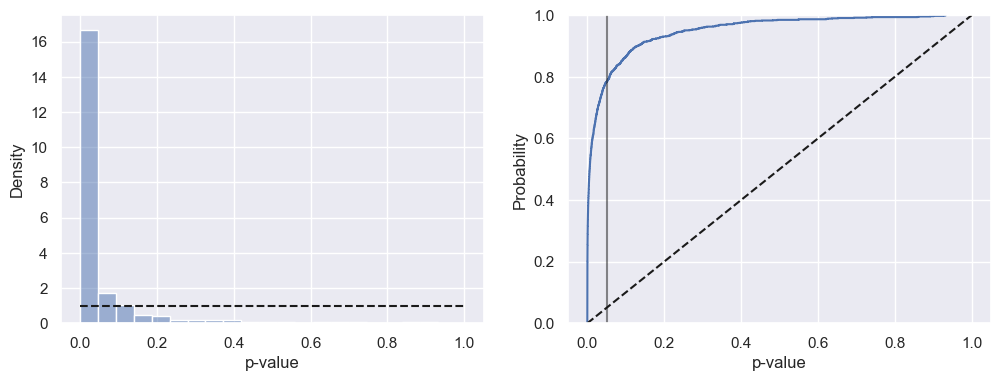

In [419]:
p_values = []
for _ in range(1000):
    a = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size)
    b = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size ) + 0.05*mu
    _, pvalue = ttest_ind(a, b)
    
    p_values.append(pvalue)
    
plot_hist_and_ecdf(p_values, add_hline=True)

При **наличии** эффекта мы должны контролировать вероятность ошибки 2-го рода, то есть
* на уровне значимости 0.0 мы должны ошибаться в среднем в 100 случаях из 100 (то есть всегда говорим, что отличий нет)
* на уровне значимости 0.05 мы должны ошибаться в среднем в 20 случаях из 100 
* на уровне значимости 1.0 мы должны ошибаться в среднем в 0 случаях из 100
(то есть всегда говорим, что отличия есть)

### Зависимые данные

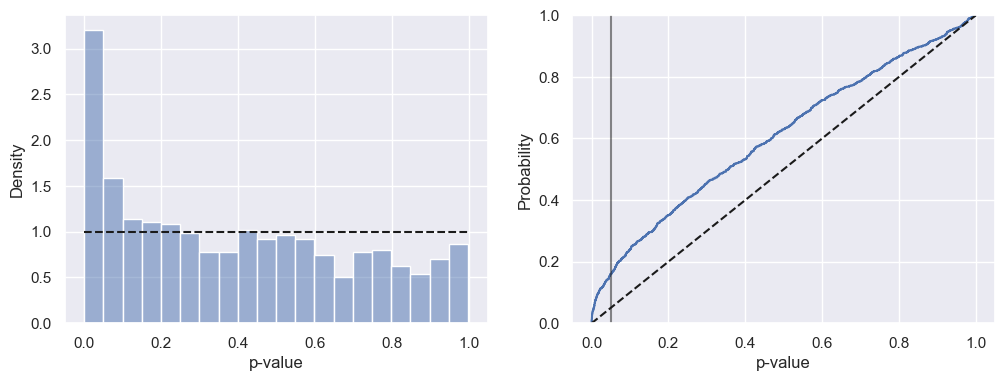

In [420]:
replication_factor = 2
p_values = []
for _ in range(1000):
    a_ = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size) 
    b_ = np.random.normal(loc=mu,
                         scale=std,
                         size=sample_size )
    a = np.concatenate([a_] * replication_factor)
    b = np.concatenate([b_] * replication_factor)
    _, pvalue = ttest_ind(a, b)
    
    p_values.append(pvalue)
    
plot_hist_and_ecdf(p_values, add_hline=True)    

$p-value$ распределено не равномерно. 
Такое поведения связано с тем, что выборка не удовлетворяет условиям регулярности t-test, в частности, наблюдения не независимы